In [8]:
from pathlib import Path
from unidecode import unidecode
import regex as re

import emoji
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 4000
pd.set_option('display.expand_frame_repr', False)


cwd = !pwd
cwd = Path(str(cwd[0]))
file_name = "murphys_clan_new.txt"
raw_file_path = cwd.parent / "raw_export" / file_name


def starts_with_timestamp(line):
    pattern = '\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2} - '
    result = re.match(pattern, line)
    if result:
        return True
    return False

def get_convo_as_list(raw_file_path):
    cleaned_data = []
    with open(raw_file_path, encoding="utf-8") as f:
        message_buffer = []
        f.readline() # Skip first line as never a message.
        while True:
            line = f.readline() 
            if not line:
                break
            line = line.strip()
            if starts_with_timestamp(line):
                if message_buffer:
                    cleaned_data.append("\n".join(message_buffer))
                message_buffer.clear()
                message_buffer.append(line)
            else:
                message_buffer.append(line)
    return cleaned_data

def get_emoji_series(raw_series):
    emoji_series = pd.Series(raw_series, name='emoji').apply(extract_emojis)
    return emoji_series

def get_raw_series(raw_text):
    return pd.Series(raw_text, name='raw').apply(lambda x: unidecode(x))

def extract_emojis(s):
    return [c for c in s if c in emoji.UNICODE_EMOJI['en']]

def process_dataframe(raw_series, rename_dict):
    df = raw_series.str.extract('(\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2})?( - .*|.*)')
    df.rename(columns={0 :'datetime', 1 :'other'}, inplace=True)
    df = process_datetime(df)
    df[["sender", "message"]] = df["other"].str.split(":", n=1, expand=True)
    df.drop("other", inplace=True, axis=1)
    df.dropna(inplace=True)
    clean_sender(df, rename_dict)
    return df

def process_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y, %H:%M')
    df['hour'] = df['datetime'].dt.strftime('%H').astype('int64')
    return df
    

def clean_sender(df, rename_dict):
    df['sender'] = df['sender'].str.replace(' - ', '')
    df['sender'].replace(to_replace=rename_dict, inplace=True)
    return df

def process_emoji_df(df):
    df = df.copy()
    df = df.explode('emoji')
    df.drop(['message'])
    return df

rename_dict = {'+44 7964 738500':'Mum'}
raw_text = get_convo_as_list(raw_file_path)
raw_series = get_raw_series(raw_text) 
df = process_dataframe(raw_series, rename_dict)    
    

## Look see of initial read in method

<AxesSubplot:>

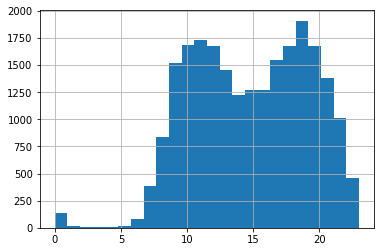

In [6]:
df.hour.hist(bins=24)

In [3]:
df.sender.value_counts()

Calum Pearson    7764
Rory Pearson     7060
Dad              5848
Mum              2302
Name: sender, dtype: int64

<AxesSubplot:>

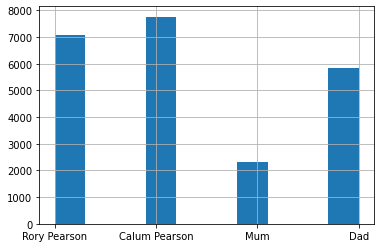

In [7]:
df.sender.hist()